In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from itertools import combinations
import missingno
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
df = pd.read_csv('/content/drive/MyDrive/CodSoft/MoviePred/IMDb Movies India.csv', encoding='latin-1')

In [45]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [46]:
df.tail()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
15504,Zulm Ko Jala Doonga,(1988),NaN,Action,4.6,11,Mahendra Shah,Naseeruddin Shah,Sumeet Saigal,Suparna Anand
15505,Zulmi,(1999),129 min,"Action, Drama",4.5,655,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani
15506,Zulmi Raj,(2005),NaN,Action,NaN,NaN,Kiran Thej,Sangeeta Tiwari,NaN,NaN
15507,Zulmi Shikari,(1988),NaN,Action,NaN,NaN,NaN,NaN,NaN,NaN
15508,Zulm-O-Sitam,(1998),130 min,"Action, Drama",6.2,20,K.C. Bokadia,Dharmendra,Jaya Prada,Arjun Sarja


# <font color="purple"><b>Data exploration</b></font>

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [48]:
df.describe()

,Rating
count,7919.000000
mean,5.841621
std,1.381777
min,1.100000
25%,4.900000
50%,6.000000
75%,6.800000
max,10.000000


In [49]:

df['Year'] = df['Year'].astype(str)
df['Year'] = df['Year'].str.extract('(\d+)')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
default_year = 1900
df['Year'] = df['Year'].replace([np.nan, np.inf, -np.inf], default_year)
df['Year'] = df['Year'].astype(int)

In [50]:
# Convert to numeric
df['Duration'] = pd.to_numeric(df['Duration'].str.strip(' min'))

In [51]:
df["Votes"]=df["Votes"].replace("$5.16M", 516)
df["Votes"] = pd.to_numeric(df['Votes'].str.replace(',',''))

In [52]:
df['Name'] = df['Name'].str.extract('([A-Za-z\s\'\-]+)')

In [53]:
# Assuming df is your DataFrame
Actor1 = df['Actor 1']
Actor2 = df['Actor 2']
Actor3 = df['Actor 3']
# Concatenating the series into one series
Actors = pd.concat([Actor1, Actor2, Actor3])

In [54]:
def Histogram(column):
    global df
    # Create a histogram using plotly.graph_objects
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=df[column]))

    fig.update_layout(title=f'Histogram of {column}',
                      xaxis_title=column,
                      yaxis_title='Frequency')

    fig.show()

In [55]:
Histogram('Rating')

In [56]:
Histogram('Duration')

In [57]:
figure = px.histogram(data_frame=df, x='Genre', title='total no of Genre', color='Genre')
figure.show()

# <font color="purple"><b>Data preprocessing</b></font>

In [58]:
df.isnull().sum().sort_values(ascending = False)

Duration    8269
Rating      7590
Votes       7590
Actor 3     3144
Actor 2     2384
Genre       1877
Actor 1     1617
Director     525
Name          10
Year           0
dtype: int64

In [59]:
def missing (h):
    missing_number = h.isnull().sum().sort_values(ascending=False)
    missing_percent = (h.isnull().sum()/h.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values
missing(df)

,Missing_Number,Missing_Percent
Duration,8269,0.533174
Rating,7590,0.489393
Votes,7590,0.489393
Actor 3,3144,0.202721
Actor 2,2384,0.153717
Genre,1877,0.121027
Actor 1,1617,0.104262
Director,525,0.033851
Name,10,0.000645
Year,0,0.000000


In [60]:
df

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,1900,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,Gadhvi,2019,109.0,Drama,7.0,8.0,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,Homecoming,2021,90.0,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,Yaaram,2019,110.0,"Comedy, Romance",4.4,35.0,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,And Once Again,2010,105.0,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali
...,...,...,...,...,...,...,...,...,...,...
15504,Zulm Ko Jala Doonga,1988,NaN,Action,4.6,11.0,Mahendra Shah,Naseeruddin Shah,Sumeet Saigal,Suparna Anand
15505,Zulmi,1999,129.0,"Action, Drama",4.5,655.0,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani
15506,Zulmi Raj,2005,NaN,Action,NaN,NaN,Kiran Thej,Sangeeta Tiwari,NaN,NaN
15507,Zulmi Shikari,1988,NaN,Action,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
df.dropna(subset=['Rating'], inplace=True)

In [62]:
df.dropna(subset=['Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre'], inplace=True)

In [65]:
df

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,Gadhvi,2019,109.000000,Drama,7.0,8.0,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,Yaaram,2019,110.000000,"Comedy, Romance",4.4,35.0,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,Aur Pyaar Ho Gaya,1997,147.000000,"Comedy, Drama, Musical",4.7,827.0,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,Yahaan,2005,142.000000,"Drama, Romance, War",7.4,1086.0,Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,A Question Mark,2012,82.000000,"Horror, Mystery, Thriller",5.6,326.0,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia
...,...,...,...,...,...,...,...,...,...,...
15501,Zulm Ki Hukumat,1992,133.439124,"Action, Crime, Drama",5.3,135.0,Bharat Rangachary,Dharmendra,Moushumi Chatterjee,Govinda
15503,Zulm Ki Zanjeer,1989,125.000000,"Action, Crime, Drama",5.8,44.0,S.P. Muthuraman,Chiranjeevi,Jayamalini,Rajinikanth
15504,Zulm Ko Jala Doonga,1988,133.439124,Action,4.6,11.0,Mahendra Shah,Naseeruddin Shah,Sumeet Saigal,Suparna Anand
15505,Zulmi,1999,129.000000,"Action, Drama",4.5,655.0,Kuku Kohli,Akshay Kumar,Twinkle Khanna,Aruna Irani


In [64]:
df['Duration'].fillna(df['Duration'].mean(), inplace=True)

In [66]:
df.isnull().sum().sort_values(ascending = False)

Name        9
Year        0
Duration    0
Genre       0
Rating      0
Votes       0
Director    0
Actor 1     0
Actor 2     0
Actor 3     0
dtype: int64

In [67]:
df.dtypes

Name         object
Year          int64
Duration    float64
Genre        object
Rating      float64
Votes       float64
Director     object
Actor 1      object
Actor 2      object
Actor 3      object
dtype: object

In [68]:
df.shape

(7558, 10)

<Axes: >

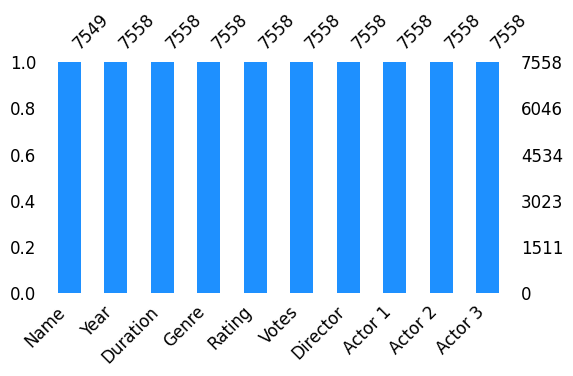

In [69]:
missingno.bar(df, color="dodgerblue", sort="ascending", figsize=(6,3), fontsize=12)

In [72]:
df['Genre'] = df['Genre'].str.split(', ')
df = df.explode('Genre')
df['Genre'].fillna(d['Genre'].mode()[0], inplace=True)

NameError: name 'd' is not defined

In [ ]:
df.head(2)

In [73]:
actor1_encoding = df.groupby('Actor 1').agg({'Rating': 'mean'}).to_dict()
actor2_encoding = df.groupby('Actor 2').agg({'Rating': 'mean'}).to_dict()
actor3_encoding = df.groupby('Actor 3').agg({'Rating': 'mean'}).to_dict()
director_encoding = df.groupby('Director').agg({'Rating': 'mean'}).to_dict()
genre_encoding = df.groupby('Genre').agg({'Rating': 'mean'}).to_dict()

In [74]:
df['actor1_encoded'] = round(df['Actor 1'].map(actor1_encoding['Rating']), 1)
df['actor2_encoded'] = round(df['Actor 2'].map(actor2_encoding['Rating']), 1)
df['actor3_encoded'] = round(df['Actor 3'].map(actor3_encoding['Rating']), 1)
df['director_encoded'] = round(df['Director'].map(director_encoding['Rating']), 1)
df['genre_encoded'] = round(df['Genre'].map(genre_encoding['Rating']), 1)

In [75]:
df.drop(['Name','Actor 1', 'Actor 2', 'Actor 3', 'Director', 'Genre'], axis=1, inplace=True)

In [76]:
df.head(2)

,Year,Duration,Rating,Votes,actor1_encoded,actor2_encoded,actor3_encoded,director_encoded,genre_encoded
1,2019,109.0,7.0,8.0,6.8,7.0,7.0,7.0,6.0
3,2019,110.0,4.4,35.0,5.2,4.4,4.5,4.4,5.7


In [77]:
X = df.drop(['Rating'], axis=1)
y = df['Rating']

In [78]:
df

,Year,Duration,Rating,Votes,actor1_encoded,actor2_encoded,actor3_encoded,director_encoded,genre_encoded
1,2019,109.000000,7.0,8.0,6.8,7.0,7.0,7.0,6.0
3,2019,110.000000,4.4,35.0,5.2,4.4,4.5,4.4,5.7
3,2019,110.000000,4.4,35.0,5.2,4.4,4.5,4.4,5.7
5,1997,147.000000,4.7,827.0,4.8,5.7,5.9,5.4,5.7
5,1997,147.000000,4.7,827.0,4.8,5.7,5.9,5.4,6.0
...,...,...,...,...,...,...,...,...,...
15504,1988,133.439124,4.6,11.0,6.1,3.4,4.6,4.0,5.4
15505,1999,129.000000,4.5,655.0,5.4,4.6,5.6,5.2,5.4
15505,1999,129.000000,4.5,655.0,5.4,4.6,5.6,5.2,6.0
15508,1998,130.000000,6.2,20.0,5.8,5.5,5.2,4.2,5.4


In [79]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.1,random_state= 22)

In [80]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_pred_train = lr.predict(X_train)
lr_pred_test = lr.predict(X_test)

In [81]:
print('Mean Squared Error (Linear Regression - Test):',   mean_squared_error(y_test, lr_pred_test))
print('Mean Absolute Error  (Linear Regression - Test): ',mean_absolute_error(y_test, lr_pred_test))
print('R2 score (Linear Regression - Train): ',           r2_score(y_train,lr_pred_train))
print('R2 Score (Linear Regression - Test):',             r2_score(y_test,lr_pred_test))

Mean Squared Error (Linear Regression - Test): 0.46439214619755637
Mean Absolute Error  (Linear Regression - Test):  0.5078404379088721
R2 score (Linear Regression - Train):  0.7504478189374881
R2 Score (Linear Regression - Test): 0.7386906025015387


In [82]:
rfg = RandomForestRegressor()
rfg.fit(X_train,y_train)
rf_pred_train = rfg.predict(X_train)
rf_pred_test = rfg.predict(X_test)

In [83]:
print('Mean Squared Error (Random Forest - Test):',mean_squared_error(y_test, rf_pred_test))
print('Mean Absolute Error  (Random Forest - Test): ',mean_absolute_error(y_test, rf_pred_test))
print('R2 score (Random Forest - Train): ',r2_score(y_train,rf_pred_train))
print('R2 Score (Random Forest - Test):',r2_score(y_test,rf_pred_test))

Mean Squared Error (Random Forest - Test): 0.08648788686605982
Mean Absolute Error  (Random Forest - Test):  0.17201820546163868
R2 score (Random Forest - Train):  0.9910985677323927
R2 Score (Random Forest - Test): 0.9513340227802412


In [84]:
# Create and train the XGBoost Regressor model
xgboost = XGBRegressor(objective='reg:squarederror', random_state=42)
xgboost.fit(X_train, y_train)
y_pred_xgboost_train = xgboost.predict(X_train)
y_pred_xgboost_test = xgboost.predict(X_test)

In [85]:
print('Mean Squared Error (xgboost - Test):', mean_squared_error(y_test, y_pred_xgboost_test))
print('Mean Absolute Error  (xgboost - Test): ',mean_absolute_error(y_test, y_pred_xgboost_test))
print('R2 score (xgboost - Train): ', r2_score(y_train, y_pred_xgboost_train))
print('R2 Score (xgboost - Test):', r2_score(y_test,y_pred_xgboost_test))

Mean Squared Error (xgboost - Test): 0.19402499513352767
Mean Absolute Error  (xgboost - Test):  0.30208498881294144
R2 score (xgboost - Train):  0.9484468140076008
R2 Score (xgboost - Test): 0.8908238328466141


In [86]:
dt = DecisionTreeRegressor(max_depth=9,random_state=42)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

In [87]:
print('Mean Squared Error (Decision Tree - Test):',mean_squared_error(y_test, y_pred_test))
print('Mean Absolute Error  (Decision Tree - Test): ',mean_absolute_error(y_test, y_pred_test))
print('R2 score (Decision Tree - Train): ',r2_score(y_train,y_pred))
print('R2 Score (Decision Tree - Test):',r2_score(y_test,y_pred_test))

Mean Squared Error (Decision Tree - Test): 0.3832810391265005
Mean Absolute Error  (Decision Tree - Test):  0.42638652903511415
R2 score (Decision Tree - Train):  0.83019589638655
R2 Score (Decision Tree - Test): 0.784331112774411
